# soilgrids <a name="introduction"></a>

This package provides a minimal wrapper for the ISRIC Soilgrids API, allowing 
users to query soil properties by latitude/longitude and perform basic 
analyses on the returned data.

Functions:

*   `get_soilgrids()`: Provides a simple wrapper for the /properties/query
    API endpoint, parsing the geojson response into a pandas DataFrame.
        
Classes:

*   `SoilGrids()`: Provides methods for querying data from Soilgrids and 
    performing aggregation, analysis, and visualisation.

Useful links:

*   Documentation for the API: <https://rest.isric.org/soilgrids/v2.0/docs>
*   ISRIC REST entry page, including fair use policy: <https://rest.isric.org>
*   ISRIC data and software policy: <https://www.isric.org/about/data-policy>
*   Soilgrids FAQ: <https://www.isric.org/explore/soilgrids/faq-soilgrids>

Contents:

*   [Introduction](#introduction)
*   [Installation](#installation)
*   [Querying data using `SoilGrids`](#querying-data)
*   [Getting the property (clay, sand, silt) with the highest value for each point](#rank-properties)
*   [Analysing the relationship between clay, sand, silt and organic carbon stock](#property-relationships)
*   [Additional features](#additional-features)
    *   [Method `SoilGrids.plot_ocs_property_relationships()`](#plot_ocs_property_relationships)
    *   [Method `SoilGrids.plot_property_map()`](#plot_property_map)
    *   [Method `SoilGrids.aggregate_means()`](#aggregate_means)
* [Testing](#testing)
* [Disclaimer/licensing](#disclaimer)

## Installatation <a name="installation"></a>

This package can be installed from GitHub using `pip`:

```bash
pip install git+https://github.com/wurli/soilgrids
```

## Querying data using `SoilGrids` <a name="querying-data"></a>

The following code reads in the mean values for clay, sand, silt, and organic 
carbon stock (OCS) in the top 30cm of soil for a random set of 50 points 
within roughly 25km of 
[Herning, Denmark](https://en.wikipedia.org/wiki/Herning). Points can be queried 
at a maximum rate of 5/minute, so the following code takes about 10 minutes to 
run:

In [1]:
from IPython.display import Markdown, Image
from soilgrids import SoilGrids
import logging
import plotly.io as pio
import plotly.offline as po

# Turn off console logs for cleaner notebook output
logging.getLogger('soilgrids').setLevel(logging.ERROR)

# Helper for displaying tables as markdown
show = lambda df: display(Markdown(df.to_markdown(index=False)))

sg = SoilGrids()

# get_points_sample() reads in a uniformly distributed random sample of
# points within specified bounds. If you wanted to query an exact set of
# points, you could use `sg.get_points()`.
sg.get_points_sample(
    50,
    lat_min=55.958103, lat_max=56.225297,
    lon_min=8.662215, lon_max=9.354390,
    soil_property=['clay', 'sand', 'silt', 'ocs'],
    depth=['0-5cm', '5-15cm', '15-30cm', '0-30cm'],
    value='mean'
)

# Once Soilgrids has been queried, the results are accessible using the 
# `data` property. For brevity, only a subset of the data is shown here.
show(sg.data[0:15].filter([
    'lat', 'lon', 'soil_property', 'mapped_units', 
    'target_units', 'depth', 'mean'
]))

|     lat |     lon | soil_property   | mapped_units   | target_units   | depth   |   mean |
|--------:|--------:|:----------------|:---------------|:---------------|:--------|-------:|
| 56.0024 | 9.17168 | clay            | g/kg           | %              | 0-5cm   |     93 |
| 56.0024 | 9.17168 | clay            | g/kg           | %              | 5-15cm  |     90 |
| 56.0024 | 9.17168 | clay            | g/kg           | %              | 15-30cm |     85 |
| 56.0024 | 9.17168 | ocs             | t/ha           | kg/m²          | 0-30cm  |     69 |
| 56.0024 | 9.17168 | sand            | g/kg           | %              | 0-5cm   |    802 |
| 56.0024 | 9.17168 | sand            | g/kg           | %              | 5-15cm  |    804 |
| 56.0024 | 9.17168 | sand            | g/kg           | %              | 15-30cm |    820 |
| 56.0024 | 9.17168 | silt            | g/kg           | %              | 0-5cm   |    105 |
| 56.0024 | 9.17168 | silt            | g/kg           | %              | 5-15cm  |    106 |
| 56.0024 | 9.17168 | silt            | g/kg           | %              | 15-30cm |     95 |
| 56.1016 | 8.93631 | clay            | g/kg           | %              | 0-5cm   |     63 |
| 56.1016 | 8.93631 | clay            | g/kg           | %              | 5-15cm  |     58 |
| 56.1016 | 8.93631 | clay            | g/kg           | %              | 15-30cm |     83 |
| 56.1016 | 8.93631 | ocs             | t/ha           | kg/m²          | 0-30cm  |     59 |
| 56.1016 | 8.93631 | sand            | g/kg           | %              | 0-5cm   |    805 |

## Getting the property (clay, sand, silt) with the highest value for each point <a name="rank-properties"></a>

The `SoilGrids` class provides a handy utility `rank_properties()` for finding
the most abundant soil types (i.e. properties) for each point. We see that 
throughout the Herning region, the main soil properties are, in order, sand, 
silt, and clay:

In [2]:
show(sg.rank_properties(
    subset=['clay', 'sand', 'silt'], 
    top_depth=0, 
    bottom_depth=30
))

|     lat |     lon | depth   | mapped_units   | property_no1   | property_no2   | property_no3   |
|--------:|--------:|:--------|:---------------|:---------------|:---------------|:---------------|
| 55.9681 | 9.19413 | 0-30cm  | g/kg           | sand: 863      | silt:  75      | clay:  62      |
| 55.969  | 8.84612 | 0-30cm  | g/kg           | sand: 858      | silt:  89      | clay:  52      |
| 55.9736 | 9.26458 | 0-30cm  | g/kg           | sand: 846      | silt:  92      | clay:  63      |
| 55.988  | 9.06893 | 0-30cm  | g/kg           | sand: 852      | silt:  96      | clay:  51      |
| 56.0024 | 9.17168 | 0-30cm  | g/kg           | sand: 812      | silt: 101      | clay:  88      |
| 56.0071 | 8.73347 | 0-30cm  | g/kg           | sand: 846      | silt:  98      | clay:  55      |
| 56.0079 | 9.1555  | 0-30cm  | g/kg           | sand: 847      | silt: 101      | clay:  52      |
| 56.0115 | 9.19478 | 0-30cm  | g/kg           | sand: 876      | silt:  73      | clay:  50      |
| 56.0116 | 9.11962 | 0-30cm  | g/kg           | sand: 854      | silt:  95      | clay:  51      |
| 56.0129 | 9.06321 | 0-30cm  | g/kg           | sand: 865      | silt:  81      | clay:  54      |
| 56.0152 | 9.09177 | 0-30cm  | g/kg           | sand: 855      | silt:  93      | clay:  52      |
| 56.0209 | 9.04625 | 0-30cm  | g/kg           | sand: 868      | silt:  75      | clay:  57      |
| 56.0215 | 9.01066 | 0-30cm  | g/kg           | sand: 870      | silt:  92      | clay:  37      |
| 56.0218 | 9.32185 | 0-30cm  | g/kg           | sand: 793      | silt: 129      | clay:  78      |
| 56.0227 | 8.77494 | 0-30cm  | g/kg           | sand: 659      | silt: 263      | clay:  77      |
| 56.0245 | 8.98394 | 0-30cm  | g/kg           | sand: 858      | silt:  96      | clay:  45      |
| 56.0293 | 8.80021 | 0-30cm  | g/kg           | sand: 786      | silt: 134      | clay:  80      |
| 56.0312 | 9.20504 | 0-30cm  | g/kg           | sand: 838      | silt: 102      | clay:  60      |
| 56.0312 | 9.33958 | 0-30cm  | g/kg           | sand: 807      | silt: 121      | clay:  71      |
| 56.0322 | 9.13423 | 0-30cm  | g/kg           | sand: 864      | silt:  83      | clay:  55      |
| 56.0327 | 8.69833 | 0-30cm  | g/kg           | sand: 857      | silt:  93      | clay:  50      |
| 56.0335 | 8.82781 | 0-30cm  | g/kg           | sand: 820      | silt: 112      | clay:  67      |
| 56.0421 | 8.89465 | 0-30cm  | g/kg           | sand: 819      | silt: 106      | clay:  74      |
| 56.0457 | 9.2178  | 0-30cm  | g/kg           | sand: 848      | silt: 101      | clay:  50      |
| 56.0524 | 9.05007 | 0-30cm  | g/kg           | sand: 846      | silt:  98      | clay:  57      |
| 56.0591 | 9.0177  | 0-30cm  | g/kg           | sand: 815      | silt: 112      | clay:  73      |
| 56.0706 | 9.04175 | 0-30cm  | g/kg           | sand: 840      | silt: 108      | clay:  53      |
| 56.0731 | 9.1996  | 0-30cm  | g/kg           | sand: 845      | silt:  93      | clay:  61      |
| 56.0768 | 9.11822 | 0-30cm  | g/kg           | sand: 857      | silt:  93      | clay:  50      |
| 56.0801 | 8.89161 | 0-30cm  | g/kg           | sand: 830      | silt: 106      | clay:  62      |
| 56.0936 | 8.88005 | 0-30cm  | g/kg           | sand: 841      | silt:  92      | clay:  65      |
| 56.1016 | 8.93631 | 0-30cm  | g/kg           | sand: 791      | silt: 138      | clay:  71      |
| 56.1029 | 9.29378 | 0-30cm  | g/kg           | sand: 759      | silt: 132      | clay: 111      |
| 56.1034 | 9.1627  | 0-30cm  | g/kg           | sand: 864      | silt:  87      | clay:  49      |
| 56.1084 | 9.21805 | 0-30cm  | g/kg           | sand: 846      | silt:  84      | clay:  71      |
| 56.1126 | 8.80794 | 0-30cm  | g/kg           | sand: 836      | silt:  98      | clay:  65      |
| 56.1153 | 8.81545 | 0-30cm  | g/kg           | sand: 833      | silt: 107      | clay:  60      |
| 56.1223 | 9.24917 | 0-30cm  | g/kg           | sand: 838      | silt:  95      | clay:  67      |
| 56.1239 | 8.72794 | 0-30cm  | g/kg           | sand: 826      | silt: 109      | clay:  65      |
| 56.124  | 8.96254 | 0-30cm  | g/kg           | sand: 810      | silt: 125      | clay:  66      |
| 56.127  | 8.91474 | 0-30cm  | g/kg           | sand: 649      | silt: 252      | clay: 100      |
| 56.1365 | 9.0808  | 0-30cm  | g/kg           | sand: 786      | silt: 111      | clay: 104      |
| 56.1644 | 9.26652 | 0-30cm  | g/kg           | sand: 801      | silt: 117      | clay:  84      |
| 56.1707 | 8.92046 | 0-30cm  | g/kg           | sand: 802      | silt: 128      | clay:  70      |
| 56.177  | 8.82983 | 0-30cm  | g/kg           | sand: 807      | silt: 136      | clay:  57      |
| 56.1878 | 9.00154 | 0-30cm  | g/kg           | sand: 870      | silt:  86      | clay:  44      |
| 56.2074 | 9.23711 | 0-30cm  | g/kg           | sand: 807      | silt: 118      | clay:  75      |
| 56.2128 | 9.33269 | 0-30cm  | g/kg           | sand: 729      | silt: 183      | clay:  87      |
| 56.2192 | 8.77554 | 0-30cm  | g/kg           | sand: 820      | silt: 115      | clay:  64      |

You may notice that the above table shows only 49 points; it is missing
(56.1462, 8.93131). This is because Soilgrids returns null values if there 
is no data available for a given point, and such cases must necessarily be 
excluded from the ranking calculation. In this case, the missing data may be 
explained by the point's close proximity to the [Herningsholm Stream](https://www.google.com/maps/place/56°08'46.3%22N+8°55'52.7%22E/@56.1462,8.9287351,17z/data=!3m1!4b1!4m4!3m3!8m2!3d56.1462!4d8.93131?entry=ttu):


In [3]:
agg = sg.aggregate_means(0, 30)
missing = agg[agg['mean'].isna()]
show(missing.filter(['lat', 'lon', 'soil_property', 'mean']))

|     lat |     lon | soil_property   |   mean |
|--------:|--------:|:----------------|-------:|
| 56.1462 | 8.93131 | clay            |    nan |
| 56.1462 | 8.93131 | sand            |    nan |
| 56.1462 | 8.93131 | silt            |    nan |
| 56.1462 | 8.93131 | ocs             |    nan |

## Analysing the relationship between clay, sand, silt and organic carbon stock <a name="property-relationships"></a>

The `ocs_correlation()` method fits and displays summary statistics for a linear 
model with clay, sand, and silt as predictors, and OCS as the response variable. 
Based on the R-squared values returned in the summary, it doesn't look like 
these soil properties are particularly good predictors for OCS in this case:

In [4]:
print(sg.ocs_correlation(capture_output=True))


Call:
lm(formula = clay + sand + silt ~ ocs, data = soilgrids_summary, 
    na.action = na.omit)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.90210 -0.83803  0.07654  0.14061  2.11926 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1000.55348    1.25964 794.314   <2e-16 ***
ocs           -0.01068    0.02040  -0.523    0.603    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.948 on 47 degrees of freedom
Multiple R-squared:  0.005796,	Adjusted R-squared:  -0.01536 
F-statistic: 0.274 on 1 and 47 DF,  p-value: 0.6031




## Additional features <a name="additional-features"></a>

### Method `SoilGrids.plot_ocs_property_relationships()` <a name="plot_ocs_property_relationships"></a>

The `plot_ocs_property_relationships()` method can be used to obtain a graphical
representation of the relationships between OCS and the other soil properties 
present in the data. These are displayed as scatterplots with overlayed lines
of best fit, i.e. the values predicted by a fitted linear regression.

In this case we can see that the plotted points never show particularly strong 
agreement with the fitted line, again providing evidence that clay, sand,
and silt are not particularly good predictors for OCS:

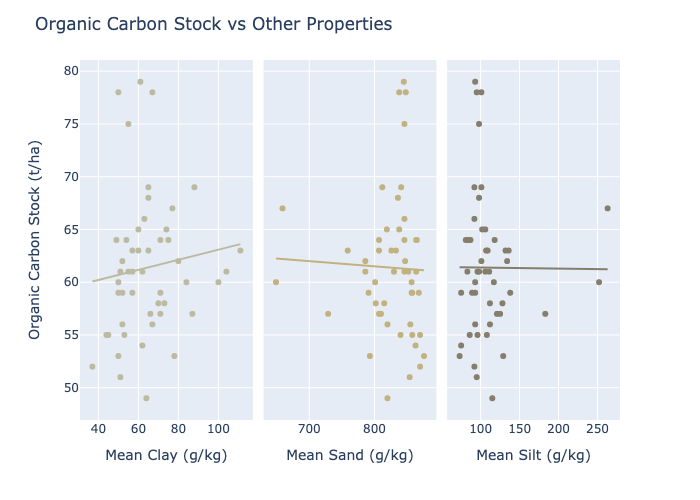

In [5]:
fig = sg.plot_ocs_property_relationships()

fig.write_image("README_files/ocs_property_relationships.png")
Image("README_files/ocs_property_relationships.png")

### Method `SoilGrids.plot_property_map()` <a name="plot_property_map"></a>

The `plot_property_map()` method can display the points as they appear 
geographically. The points are sized according to the value of the property
you choose to plot, and the tooltip also displays the values for other 
properties present in the data:

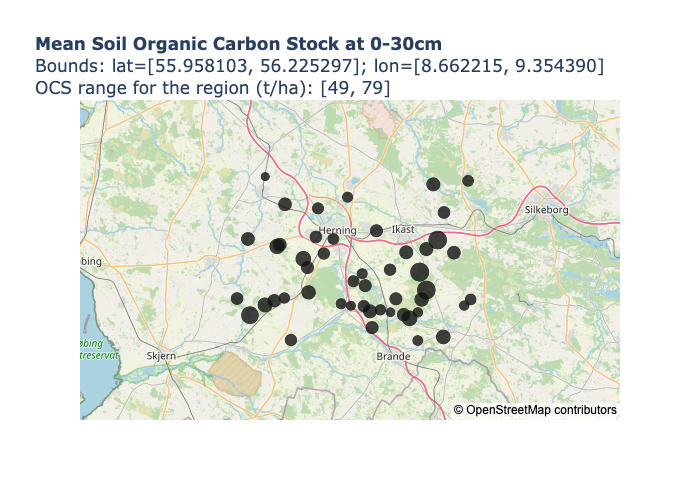

In [6]:
fig = sg.plot_property_map('ocs', zoom=8)

fig.write_image("README_files/property_map_ocs.png")
Image("README_files/property_map_ocs.png")

### Method `SoilGrids.aggregate_means()` <a name="aggregate_means"></a>

Working with data from SoilGrids poses a challenge since different soil 
properties are measured at different levels of granularity. For example, values
for clay are provided at depths 0-5cm, 5-15cm, and 15-30cm, whereas OCS is 
provided as a single value for 0-30cm as a whole.

In order to compare OCS with clay, we need to aggregate the values for clay to 
get a representative mean value for the whole 0-30cm. However, since the 3 
values for clay don't all cover the same amount of depth (they cover 5, 10 and 
15 centimetres respectively), we can't simply take another average to obtain
a figure.

`SoilGrids.aggregate_means()` is a utility for aggregating the mean values
provided by Soilgrids by weighting individual values according to the total 
depth they represent. This method is crucial to most of the data analysis in 
this package. The following shows how mean values are aggregated for a single 
point:

In [7]:
small_datasets = [
    dataset \
        .filter(['lat', 'lon', 'soil_property', 'depth', 'mean']) \
        .query(
            "lat == 55.968112 & lon == 9.194132 &"
            "soil_property in ['clay', 'ocs']"
        )
    for dataset in [sg.data, sg.aggregate_means(top_depth=0, bottom_depth=30)]
]

for dataset in small_datasets:
    show(dataset)

|     lat |     lon | soil_property   | depth   |   mean |
|--------:|--------:|:----------------|:--------|-------:|
| 55.9681 | 9.19413 | clay            | 0-5cm   |     58 |
| 55.9681 | 9.19413 | clay            | 5-15cm  |     49 |
| 55.9681 | 9.19413 | clay            | 15-30cm |     72 |
| 55.9681 | 9.19413 | ocs             | 0-30cm  |     54 |

|     lat |     lon | soil_property   | depth   |   mean |
|--------:|--------:|:----------------|:--------|-------:|
| 55.9681 | 9.19413 | clay            | 0-30cm  |     62 |
| 55.9681 | 9.19413 | ocs             | 0-30cm  |     54 |

## Testing <a name="testing"></a>

This package is thoroughly tested using 
[pytest](https://docs.pytest.org/en/7.4.x/). To run the test suite, use:

```bash
python -m pytest tests
```

## Disclaimer/licensing <a name="disclaimer"></a>

*   Use of Soilgrids data is subject to [ISRIC data and software policy](https://www.isric.org/about/data-policy).
*   This package is licensed as [GPL-2](LICENSE).